overall, using K's architecture instead of local PCN, we can achieve same type qualitative conclusions: more cycles -> better performance.

In [1]:
from sys import path
from os.path import relpath, realpath, abspath, join, exists
from itertools import product, chain

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

pd.set_option('display.max_rows', 999)

In [2]:
from torchnetjson.builder import build_net

In [3]:
from thesis_v2 import dir_dict
from thesis_v2.data import load_data_helper
from thesis_v2.training.training_aux import load_training_results
# I forgot how this count_params handles BN buffer parameters (running mean and std) looks like it's ignored.
from thesis_v2.training_extra.misc import count_params
from thesis_v2.models.maskcnn_polished_with_rcnn_k_bl.builder import load_modules

load_modules()

In [4]:
from thesis_v2.configs.model.maskcnn_polished_with_rcnn_k_bl import (
    explored_models_20200509_cb19 as param_iterator_obj,
    keygen
)

In [5]:
# compute ccmax
from strflab.stats import cc_max
from thesis_v2.data.prepared.cadena_plos_cb19 import get_neural_data_per_trial

cc_max_all_neurons = cc_max(get_neural_data_per_trial(fill_value='zero'))
assert cc_max_all_neurons.shape == (115,)

In [6]:
def load_everything():
    _df_collect = []
    for idx, param in enumerate(
        chain(
            param_iterator_obj().generate(),
        )
    ):
        if idx % 100 == 0:
            print(idx)
            
#         if idx >= 100:
#             break
            
#         print(len(param))
#         print(len(param))

        if param['kernel_size_l23'] != 3:
            continue

#         if len(param) == 22:
#             param['train_keep'] = None
        assert len(param) == 24
        
        assert param['kernel_size_l1'] == 9
        assert param['ff_1st_block']
        
        
        
        assert param['split_seed'] == 0
        assert param['pooling_ksize'] == 3
        assert param['pooling_type'] == 'avg'
        assert not param['bn_after_fc']
        assert param['rcnn_bl_psize'] == 1
        assert param['rcnn_bl_ptype'] is None
        assert param['input_size'] == 40
        
        # 12 to go
        # remove smoothness_name and scale_name, 10 to go
        
#         assert param['model_seed'] == 0
        
        key = keygen(**{k: v for k, v in param.items() if k not in {'scale', 'smoothness'}})
        # 10 to go.
        result = load_training_results(key, return_model=False)
        # load twice, first time to get the model.
        result = load_training_results(key, return_model=True, model=build_net(result['config_extra']['model']))
        num_epochs = [len(x) for x in result['stats_all']]
        
        cc_raw = np.asarray(result['stats_best']['stats']['test']['corr'])
        assert cc_raw.shape == (115,)
        
#         if param['train_keep'] is None:
#             param['train_keep'] = 5120
        
        _df_collect.append(
            {
                'train_keep': param['train_keep'],
                'act_fn': param['act_fn'],
                'loss_type': param['loss_type'],
                'scale': float(param['scale']),
                'smoothness': float(param['smoothness']),
                'num_layer': param['num_layer'],
                'out_channel': param['out_channel'],
                # 4 to go.
                '1st_bn_before_act': param['ff_1st_bn_before_act'],
                'rcnn_bl_cls': param['rcnn_bl_cls'],
                'rcnn_acc_type': param['rcnn_acc_type'],

                'model_seed': param['model_seed'],
                # done,
                'corr_test': ((cc_raw/cc_max_all_neurons)**2).mean(),
                'max_epoch': max(num_epochs),
                'num_param': count_params(result['model']),
            }
        )
    _df =  pd.DataFrame(_df_collect, columns=[
#             'split_seed',
        'train_keep',
        'act_fn',
        'loss_type', 'scale', 'smoothness', 'num_layer',
        'out_channel', '1st_bn_before_act',

        'rcnn_bl_cls',
#         'rcnn_acc_type',
        'model_seed',

        'corr_test',
        'num_param',
        'max_epoch',
    ])
#     print(_df)
    _df = _df.set_index([
        'train_keep',
        'act_fn',
        'loss_type', 'scale', 'smoothness', 'num_layer',
        'out_channel', '1st_bn_before_act',
        'rcnn_bl_cls',
#         'rcnn_acc_type',
        'model_seed',
    ], verify_integrity=True)
    return _df

In [7]:
df = load_everything()

0
100
200
300
400
500
600
700


In [8]:
corr_mean = df['corr_test'].unstack('model_seed').mean(axis=1)

# mean, max, min, all the same. for num_param
num_param = df['num_param'].unstack('model_seed').mean(axis=1)

In [9]:
# let's try to quickly eliminate bad configs, just like before, by plotting scatter plots.
def scatter(x, y, xlabel, ylabel, title):
    plt.close('all')
    plt.figure(figsize=(6, 5))
    plt.scatter(x, y, s=1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axis('equal')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.plot([0,1],[0,1],linestyle='--')
    plt.title(title)
    plt.show()
    print('y-x mean', (y-x).mean(), 'y-x>0 mean', ((y-x)>0).mean())
    print('y top', y.max(), 'x top', x.max())

In [10]:
# here, I need to check the effective ness of act_fn, bn_before_act, bn_after_fc, loss_type
def check_compare_one_case(series_in, label_to_unstack, values_to_check=None):
    df_unstacked = series_in.unstack(label_to_unstack)
#     assert df_unstacked.shape[1] == 2
    if values_to_check is None:
        values_to_check = df_unstacked.columns.values[:2].tolist()
    else:
        pass
    
    assert len(values_to_check) == 2
    label_x = values_to_check[0]
    label_y = values_to_check[1]
        
    data_x = df_unstacked.loc[:,label_x].values
    data_y = df_unstacked.loc[:,label_y].values
    
    
    
    scatter(data_x, data_y, str(label_x), str(label_y), f'{label_to_unstack}: {label_y} vs {label_x}')

(32, 4)
[1, 2, 3, 4]
n 32
2 - 1 mean 0.0049472215197129445 sem 0.0017188740727864472
3 - 2 mean 0.0034082458737130106 sem 0.0014413138010067204
4 - 3 mean -0.001087517870942743 sem 0.0010584780391054008
4 - 2 mean 0.0023207280027702677 sem 0.0017786951864205375


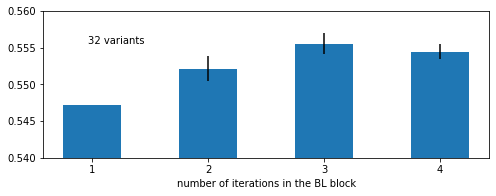

[0.5471757740718349, 0.5521229955915479, 0.5555312414652608, 0.554443723594318] [ 0.90413753  0.6172983  -0.19576178]


,num_of_cycles,performance,gain %
0,1,0.547176,NaN
1,2,0.552123,0.904138
2,3,0.555531,0.617298
3,4,0.554444,-0.195762


In [11]:
def plot_step_increase(df_this, pairs_to_check, ylim):
    # remove those no innner act ones.
    df_unstacked = df_this.unstack('rcnn_bl_cls')
#     df_unstacked = corr_mean.unstack('pcn_cls')
    print(df_unstacked.shape)
    
#     selector = df_unstacked.values[:,0] >= 0.50
    selector = ()
#     print(selector.mean())
    
    cls_values = df_unstacked.columns.values.tolist()
    print(cls_values)
    assert cls_values == list(range(1,len(cls_values)+1))
    
    n = df_unstacked.shape[0]
    
#     n = selector.sum()
    print('n', n)
    
    
    for p1, p2 in pairs_to_check:
        val0 = df_unstacked.values[:,p1-1][selector]
        val1 = df_unstacked.values[:,p2-1][selector]

        # selection
        print(
            f'{p2} - {p1}',
            'mean', (val1-val0).mean(),
            'sem', (val1-val0).std()/np.sqrt(n)
        )
        
    # time to plot.
    # show results for cls_values[0] through cls_values[-1]
    # for the first one, just show mean,
    # for others show mean and s.e.m. of increase.
    
    mean_performance = []
    sem_increase = []
    labels = []
    
    for idx, cls_name in enumerate(cls_values):
        assert idx == cls_name - 1
        mean_performance.append(df_unstacked.values[:,idx][selector].mean())
        if idx == 0:
            sem_increase.append(0.0)
        else:
            sem_increase.append((df_unstacked.values[:,idx][selector]-df_unstacked.values[:,idx-1][selector]).std()/np.sqrt(n))
        labels.append(str(cls_name))
        
    
    plt.close('all')
    fig = plt.figure(figsize=(8,3))
    plt.bar(np.arange(len(cls_values)), mean_performance, 0.5, yerr=sem_increase)
#     plt.ylabel('neural prediction performance')
    plt.ylim(*ylim)
    plt.xlabel('number of iterations in the BL block')
    plt.xticks(np.arange(len(cls_values)), labels)
    
    
    plt.text(0.1, 0.8, f'{n} variants', verticalalignment='center', horizontalalignment='left', transform=plt.gca().transAxes)
    fig.subplots_adjust(bottom=0.2)

    plt.show()
    
    print(mean_performance, np.diff(mean_performance)/mean_performance[:-1]*100)
    
    return pd.DataFrame(
        data = {
            'num_of_cycles': cls_values,
            'performance': mean_performance,
            'gain %': np.concatenate([np.asarray([np.nan]),  np.diff(mean_performance)/mean_performance[:-1]*100])
        },
        columns = ['num_of_cycles', 'performance', 'gain %']
    )
    
    
    
# trend for 0-1-2 is good. then bad.
plot_step_increase(corr_mean.xs(4640, level='train_keep'), [(1,2),(2,3),(3,4),(2,4)], (0.54, 0.56))

(32, 4)
[1, 2, 3, 4]
n 32
2 - 1 mean 0.017126582223197066 sem 0.005314228596332361
3 - 2 mean 0.004006017349186604 sem 0.001655733840834522
4 - 3 mean -0.00012417000355463038 sem 0.0018126722502529854
4 - 2 mean 0.0038818473456319735 sem 0.001774039412718124


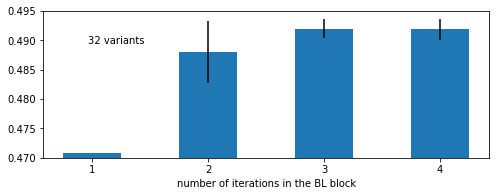

[0.47085090817887204, 0.4879774904020691, 0.49198350775125566, 0.4918593377477011] [ 3.63736842  0.82094306 -0.02523865]


,num_of_cycles,performance,gain %
0,1,0.470851,NaN
1,2,0.487977,3.637368
2,3,0.491984,0.820943
3,4,0.491859,-0.025239


In [12]:
plot_step_increase(corr_mean.xs(2320, level='train_keep'), [(1,2),(2,3),(3,4),(2,4)], (0.47, 0.495))

(32, 4)
[1, 2, 3, 4]
n 32
2 - 1 mean 0.014661966789994322 sem 0.009060992001512252
3 - 2 mean 0.0010581449738067813 sem 0.004322499887174981
4 - 3 mean 0.006332352753604555 sem 0.0032209079721861383
4 - 2 mean 0.007390497727411336 sem 0.004891096600706056


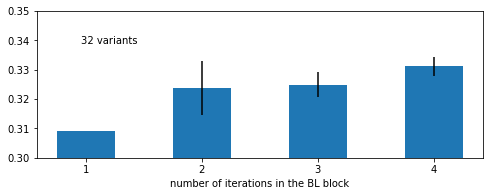

[0.30913234417032015, 0.3237943109603144, 0.32485245593412126, 0.3311848086877258] [4.74294168 0.32679542 1.94930118]


,num_of_cycles,performance,gain %
0,1,0.309132,NaN
1,2,0.323794,4.742942
2,3,0.324852,0.326795
3,4,0.331185,1.949301


In [13]:
plot_step_increase(corr_mean.xs(2320//2, level='train_keep'), [(1,2),(2,3),(3,4),(2,4)], (0.3, 0.35))

In [14]:
# check relationship between num_param and performance, colored for different num_of_cycles.

training size 1160


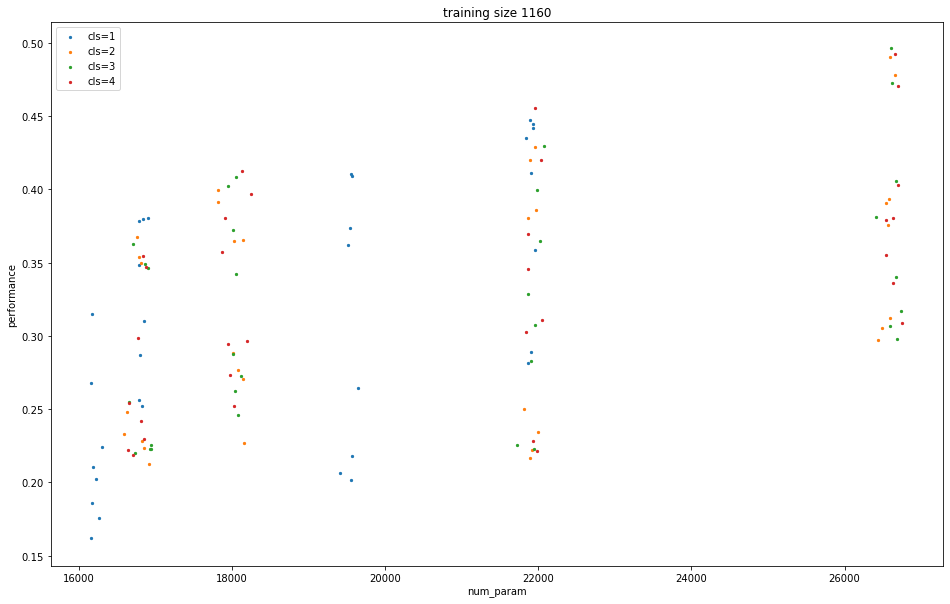

training size 2320


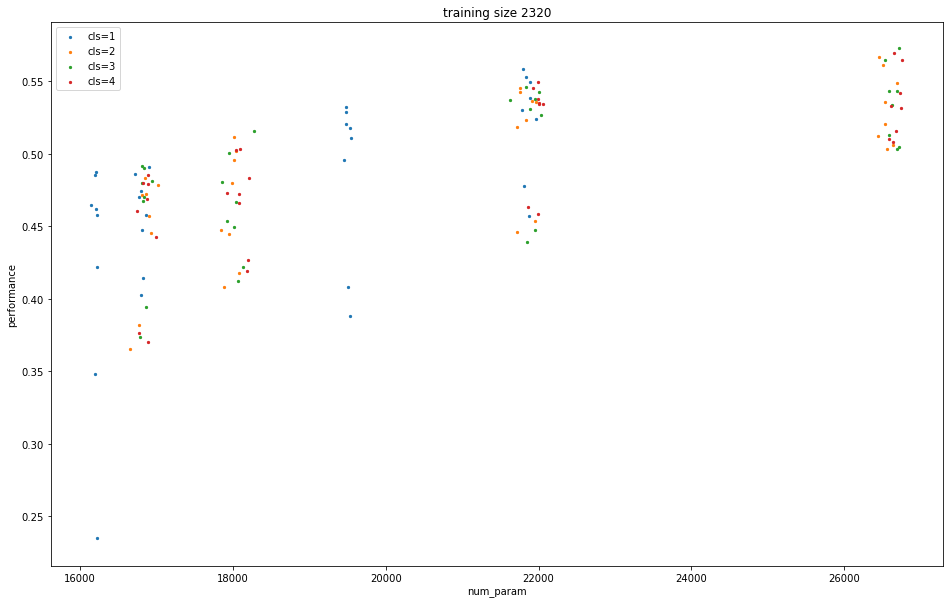

training size 4640


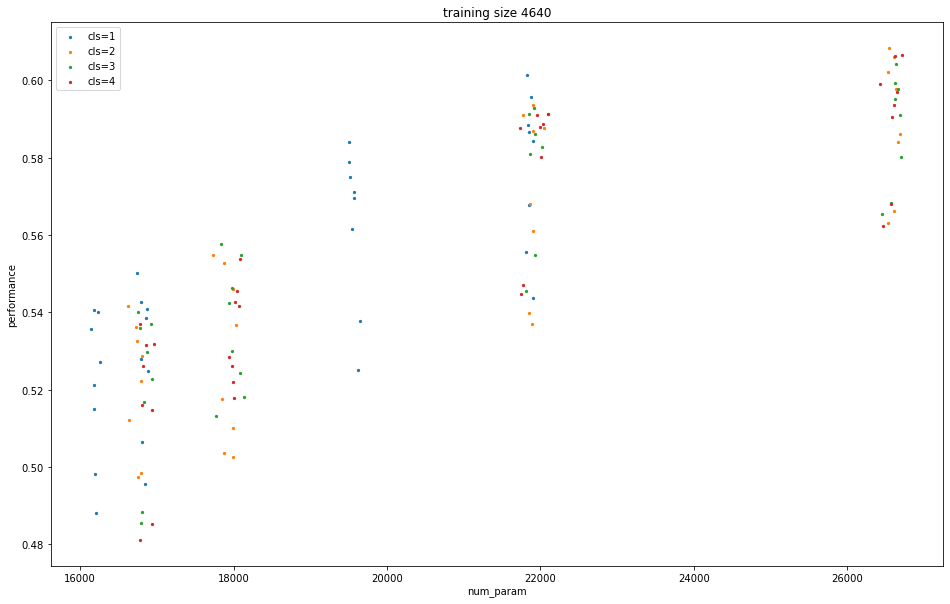

In [15]:
def check_relationship_between_num_param_and_perf_given_different_cycle():
    assert corr_mean.shape == num_param.shape
    assert corr_mean.index.equals(num_param.index)
    corr_mean_local = corr_mean.rename('corr_mean')
    num_param_local = num_param.rename('num_param')
    
    # combine them.
    df_to_check = pd.concat([corr_mean_local, num_param_local], axis=1)
    
    training_sizes = df_to_check.index.get_level_values('train_keep').unique()
    
    
    for training_size_this in training_sizes:
        print('training size', training_size_this)
        check_relationship_between_num_param_and_perf_given_different_cycle_inner(
            df_to_check.xs(training_size_this, level='train_keep'),
            title=f'training size {training_size_this}'
        )

def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(*arr.shape) * stdev
        
def check_relationship_between_num_param_and_perf_given_different_cycle_inner(df_to_check, title):
    cycle_list = df_to_check.index.get_level_values('rcnn_bl_cls').unique()
    
    plt.close('all')
    plt.figure(figsize=(16, 10))
    
    for c in cycle_list:
        data_this = df_to_check.xs(c, level='rcnn_bl_cls')
        plt.scatter(
            rand_jitter(data_this['num_param'].values),
            rand_jitter(data_this['corr_mean'].values),
            s=5,
            label=f'cls={c}',
        )
    
    plt.legend(loc='best')
#     plt.xlim(0,1)
#     plt.ylim(0,1)
#     plt.plot([0,1],[0,1],linestyle='--')
    plt.title(title)
    plt.xlabel('num_param')
    plt.ylabel('performance')
    
    
    plt.show()

check_relationship_between_num_param_and_perf_given_different_cycle()
# with similar number of parameters, I think definitely more cycles can lead to better results.